### Explore SIREN

https://colab.research.google.com/github/vsitzmann/siren/blob/master/explore_siren.ipynb#scrollTo=JMOfAQiuA0_J

In [50]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=True,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for _ in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        # coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=1, out_features=32, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=32, out_features=32, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=32, out_features=32, bias=True)
    )
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)
net.0.linear.weight torch.Size([32, 1])
net.0.linear.bias torch.Size([32])
net.1.linear.weight torch.Size([32, 32])
net.1.linear.bias torch.Size([32])
net.2.linear.weight torch.Size([32, 32])
net.2.linear.bias torch.Size([32])
net.3.weight torch.Size([1, 32])
net.3.bias torch.Size([1])


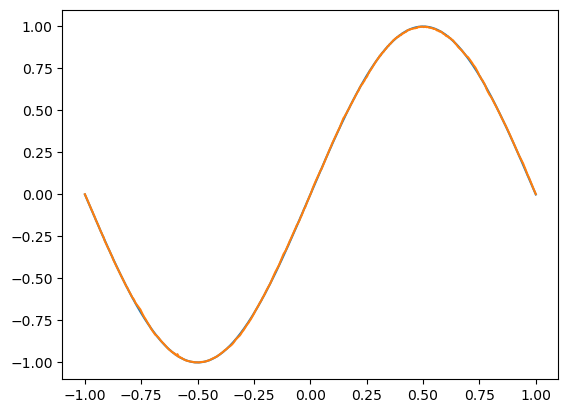

In [51]:
siren = Siren(in_features=1, out_features=1, hidden_features=32,
                  hidden_layers=2, outermost_linear=True, first_omega_0=100, hidden_omega_0=100)

x = torch.linspace(-1, 1, 1000).unsqueeze(1)
y = torch.sin(x * np.pi)

epochs = 1000
lr = 1e-3
optim = torch.optim.Adam(siren.parameters(), lr=lr)
for epoch in range(epochs):
    y_pred = siren(x)
    loss = torch.mean((y_pred - y) ** 2)
    optim.zero_grad()
    loss.backward()
    optim.step()

plt.plot(x, y, label='Ground truth')
plt.plot(x, y_pred.detach(), label='SIREN')

print(siren)
for name, param in siren.named_parameters():
    print(name, param.shape)

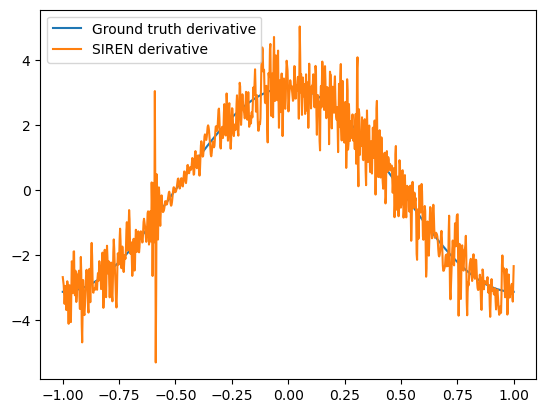

In [52]:
# compute derivative, with torch.func
dy = np.pi * torch.cos(x * np.pi)
# # dy_pred_fun = torch.func.grad(siren)(x)
single_fun = lambda x: siren(x)[0]
dy_single_fun = lambda x: torch.func.grad(single_fun)(x)
dy_pred_fun = lambda x: torch.func.vmap(dy_single_fun)(x)

dy_pred = dy_pred_fun(x)

plt.plot(x, dy, label='Ground truth derivative')
plt.plot(x, dy_pred.detach(), label='SIREN derivative')
plt.legend()